## **CV PROJECT**
- By Najeeb Saiyed
- Godcares
- Ankit

In [1]:
import os
import cv2
import random
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, regularizers, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
import matplotlib.pyplot as plt


Using TensorFlow backend.


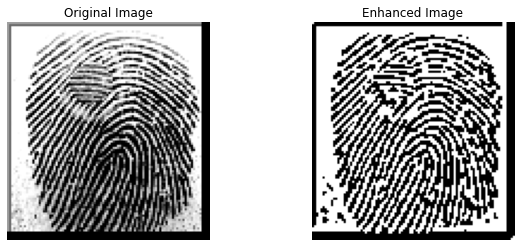

In [4]:
def enhance_image(image_path):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    img_blur = cv2.GaussianBlur(img, (3, 3), 0)
        
    # Apply adaptive thresholding filter
    img_final = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY, 11, 2)
    
    return img, img_final

def display_images(original, enhanced):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title('Enhanced Image')
    plt.axis('off')
    
    plt.show()

# Specify the path to your image
image_path = '/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy/100__M_Left_index_finger_CR.BMP'

# Apply the enhancement
original_img, enhanced_img = enhance_image(image_path)

# Display the images
display_images(original_img, enhanced_img)


# Preprocessing

### Load the raw dataset, and resize the images so that they can fit CNN's input_shape.

In [5]:
import os
import cv2

img_size = 96

def load_data(path, train=True):
    print("Loading data from:", path)
    data = []
    for img in os.listdir(path):
        imgname, ext = os.path.splitext(img)
        ID, etc = imgname.split('__')
        ID = int(ID) - 1  # to_categorical encodes starting from 0
        if train:
            _, lr, finger, _, _ = etc.split('_')
        else:
            _, lr, finger, _ = etc.split('_')
        if lr == 'Left':
            base = 0  # left hand corresponding to 0-4
        else:
            base = 5  # right hand corresponding to 5-9
        if finger == "little":
            fingerNum = base + 0
        elif finger == 'ring':
            fingerNum = base + 1
        elif finger == 'middle':
            fingerNum = base + 2
        elif finger == 'index':
            fingerNum = base + 3
        else:
            fingerNum = base + 4
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        
        # Apply slight blur
        img_blur = cv2.GaussianBlur(img_array, (3, 3), 0)
        
        # Apply adaptive thresholding filter
        img_thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
        
        img_resize = cv2.resize(img_thresh, (img_size, img_size))
        data.append([ID, fingerNum, img_resize])
    return data


In [6]:
Altered_path = "../input/socofing/SOCOFing/Altered/Altered-"
Real_path = "../input/socofing/SOCOFing/Real"

Easy_data = load_data(Altered_path+'Easy', train=True)
Medium_data = load_data(Altered_path+'Medium', train=True)
Hard_data = load_data(Altered_path+'Hard', train=True)
Real_data = load_data(Real_path, train=False)

Altered_data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
del Easy_data, Medium_data, Hard_data # Free some memory

Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Easy
Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Medium
Loading data from:  ../input/socofing/SOCOFing/Altered/Altered-Hard
Loading data from:  ../input/socofing/SOCOFing/Real


### Create two datasets, SubjectID datasets and fingerNum datasets. They will be used to train two different models in the next step.

In [7]:
X_Altered, y_SubjectID_Altered, y_fingerNum_Altered = [], [], []

for SubjectID, fingerNum, feature in Altered_data:
    X_Altered.append(feature)
    y_SubjectID_Altered.append(SubjectID)
    y_fingerNum_Altered.append(fingerNum)

X_Altered = np.array(X_Altered).reshape(-1, img_size, img_size, 1)
X_Altered = X_Altered / 255.0 # Normalize to [0, 1]
y_SubjectID_Altered = to_categorical(y_SubjectID_Altered, num_classes=600) # 600 persons in total
y_fingerNum_Altered = to_categorical(y_fingerNum_Altered, num_classes=10) # 10 fingers per person

X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val = train_test_split(
    X_Altered, y_SubjectID_Altered, test_size=0.2, random_state=2)
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

In [8]:
X_test, y_SubjectID_test, y_fingerNum_test = [], [], []

for SubjectID, fingerNum, feature in Real_data:
    X_test.append(feature)
    y_SubjectID_test.append(SubjectID)
    y_fingerNum_test.append(fingerNum)

X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0

y_SubjectID_test = to_categorical(y_SubjectID_test, num_classes=600)
y_fingerNum_test = to_categorical(y_fingerNum_test, num_classes=10)

### Output the shapes of all datasets to confirm our previous work.

In [9]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", X_Altered.shape, y_SubjectID_Altered.shape)
print("SubjectID_Train:      ", X_SubjectID_train.shape, y_SubjectID_train.shape)
print("SubjectID_Validation: ", X_SubjectID_val.shape, y_SubjectID_val.shape)
print("SubjectID_Test:       ", X_test.shape, y_SubjectID_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", X_Altered.shape, y_fingerNum_Altered.shape)
print("fingerNum_Train:      ", X_fingerNum_train.shape, y_fingerNum_train.shape)
print("fingerNum_Validation: ", X_fingerNum_val.shape, y_fingerNum_val.shape)
print("fingerNum_Test:       ", X_test.shape, y_fingerNum_test.shape)

del Altered_data, Real_data, y_SubjectID_Altered # Free some memory again

Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (49270, 96, 96, 1) (49270, 600)
SubjectID_Train:       (39416, 96, 96, 1) (39416, 600)
SubjectID_Validation:  (9854, 96, 96, 1) (9854, 600)
SubjectID_Test:        (6000, 96, 96, 1) (6000, 600)
----------------------------------------------------
full fingerNum data:   (49270, 96, 96, 1) (49270, 10)
fingerNum_Train:       (39416, 96, 96, 1) (39416, 10)
fingerNum_Validation:  (9854, 96, 96, 1) (9854, 10)
fingerNum_Test:        (6000, 96, 96, 1) (6000, 10)


### Build two models(set net=2). In these models, I introduce several methods to prevent overfitting, including L2 regularization, BatchNormalization, Dropout regularization, EarlyStopping and ReduceLROnPlateau.

In [10]:
nets = 2
model = [0] * nets
final_Dense_units = [600, 10]
model_name = ['SubjectID_Mod', 'FingerNum_Mod']
for i in range(nets):
    model[i] = Sequential(name=model_name[i])

    model[i].add(layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape = (96, 96, 1)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(64,(5, 5), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Conv2D(128,(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model[i].add(layers.BatchNormalization())
    model[i].add(layers.MaxPool2D((2, 2)))
    model[i].add(layers.Dropout(0.3))
    model[i].add(layers.Flatten())
    model[i].add(layers.Dense(256, activation='relu'))
    model[i].add(layers.Dropout(0.4))
    model[i].add(layers.Dense(final_Dense_units[i], activation='softmax'))

    # Complete with Adam optimizer and entropy cost
    model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
    model[i].summary()

Model: "SubjectID_Mod"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 32)        832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 42, 42, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 19, 128)     

### Delete the second dataset temporarily due to the overloading problem.

In [11]:
# Because of the RAM limitatiaon, two dataset will cause overloaded problem
# Thus no enougth remaining RAM for models fitting
# So I delete the fingerNum dataset before the SubjectID model fitting, then reload it when needed.
del X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val

### Fit the models. Attention! Here the min_lr in ReduceLROnPlateau are different becasue of facts.

In [14]:
history = [0] * nets
CallBack = [0] * nets
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 20
batch_size = 64
for i in range(nets):
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1),
        callbacks.ReduceLROnPlateau(factor=0.1, patience=1, min_lr=ReduceLR_minlr[i], verbose=1)]
history[0] = model[0].fit(X_SubjectID_train, y_SubjectID_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_SubjectID_val, y_SubjectID_val),
                    verbose = 1, callbacks= CallBack[0])

Train on 39416 samples, validate on 9854 samples
Epoch 1/20
39416/39416 [==============================] - 21s 532us/step - loss: 6.1421 - accuracy: 0.0181 - val_loss: 5.6127 - val_accuracy: 0.0716
Epoch 2/20
39416/39416 [==============================] - 21s 524us/step - loss: 5.0724 - accuracy: 0.0976 - val_loss: 3.8999 - val_accuracy: 0.3543
Epoch 3/20
39416/39416 [==============================] - 21s 526us/step - loss: 3.3960 - accuracy: 0.3190 - val_loss: 2.1691 - val_accuracy: 0.7118
Epoch 4/20
39416/39416 [==============================] - 21s 523us/step - loss: 1.9600 - accuracy: 0.5830 - val_loss: 0.9621 - val_accuracy: 0.8904
Epoch 5/20
39416/39416 [==============================] - 21s 524us/step - loss: 1.1400 - accuracy: 0.7597 - val_loss: 0.5599 - val_accuracy: 0.9435
Epoch 6/20
39416/39416 [==============================] - 21s 524us/step - loss: 0.7401 - accuracy: 0.8522 - val_loss: 0.4062 - val_accuracy: 0.9630
Epoch 7/20
39416/39416 [==============================] -

### Delete the first datset and reload the second dataset. The fit the model.

In [15]:
# Delete the SubjectID dataset after it was used
del X_SubjectID_train, X_SubjectID_val, y_SubjectID_train, y_SubjectID_val
# Then reload fingerNum dataset before model fitting
X_fingerNum_train, X_fingerNum_val, y_fingerNum_train, y_fingerNum_val = train_test_split(
    X_Altered, y_fingerNum_Altered, test_size=0.2, random_state=2)

del X_Altered, y_fingerNum_Altered

history[1] = model[1].fit(X_fingerNum_train, y_fingerNum_train,
                    batch_size = batch_size,
                    epochs = epochs, 
                    validation_data = (X_fingerNum_val, y_fingerNum_val),
                    verbose = 1, callbacks= CallBack[1])

Train on 39416 samples, validate on 9854 samples
Epoch 1/20
39416/39416 [==============================] - 22s 555us/step - loss: 1.7520 - accuracy: 0.4342 - val_loss: 1.2721 - val_accuracy: 0.5913
Epoch 2/20
39416/39416 [==============================] - 21s 524us/step - loss: 1.2104 - accuracy: 0.6143 - val_loss: 1.0019 - val_accuracy: 0.6968
Epoch 3/20
39416/39416 [==============================] - 20s 519us/step - loss: 0.9114 - accuracy: 0.7176 - val_loss: 0.6875 - val_accuracy: 0.8127
Epoch 4/20
39416/39416 [==============================] - 21s 523us/step - loss: 0.6800 - accuracy: 0.8004 - val_loss: 0.4624 - val_accuracy: 0.9016
Epoch 5/20
39416/39416 [==============================] - 21s 523us/step - loss: 0.4986 - accuracy: 0.8691 - val_loss: 0.3871 - val_accuracy: 0.9181
Epoch 6/20
39416/39416 [==============================] - 20s 519us/step - loss: 0.3832 - accuracy: 0.9088 - val_loss: 0.2695 - val_accuracy: 0.9596
Epoch 7/20
39416/39416 [==============================] -

### Visualize the training process with accuarcy and loss, so we can adjust hyperparameters incording to these feedbacks.

Id recognition accuracy:  99.75000023841858 %
Finger recognition accuracy:  99.90000128746033 %


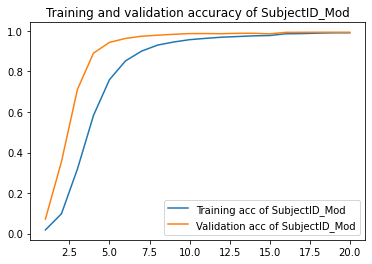

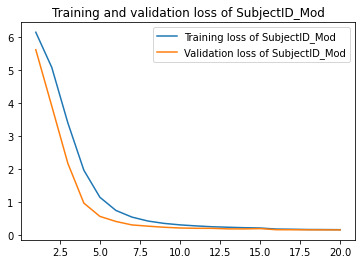

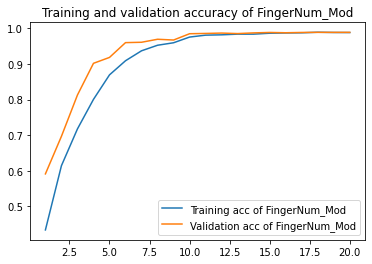

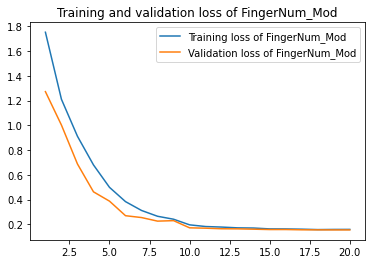

In [16]:
acc = [0] * nets
val_acc = [0] * nets
loss = [0] * nets
val_loss = [0] * nets
for i in range(nets):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    plt.figure()
    plt.plot(epochs, acc[i], label='Training acc of '+model_name[i])
    plt.plot(epochs, val_acc[i], label='Validation acc of '+model_name[i])
    plt.title('Training and validation accuracy of '+model_name[i])
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss[i],  label='Training loss of '+model_name[i])
    plt.plot(epochs, val_loss[i], label='Validation loss of '+model_name[i])
    plt.title('Training and validation loss of '+model_name[i])
    plt.legend()

testing_acc_Id = model[0].evaluate([X_test], [y_SubjectID_test], verbose=0)
print("Id recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([X_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

### Visulize the predictions' of fingername to get a intuitional conclusion about how the model worked.

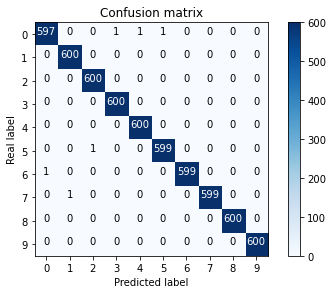

In [17]:
# Visualize finger prediction with confusion matrix 
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')

# Predict the values from the test dataset
y_fingerNum_pred = model[1].predict(X_test)
# Convert predictions classes to one hot vectors 
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1) 
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

### Finally, randomly pick a fingerprint from test data to predict both its Id and fingername. When both the predictions are correct, then we can say this kernel works great with two models. Notice that the reason I choose ID and fingername as the labels of this kernel is that we usually verify a person's finger with his ID and the fingername. Of course you can choose others features as your label if you want!

Infomation confirm! Fingerprint matches: person Id 144 right index


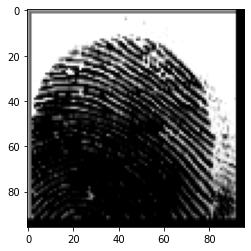

In [18]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "
    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else: fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, X_test.shape[0]-1)
plt.imshow(X_test[rand_fp_num].reshape((96, 96)), cmap ='gray')
y_SubjectID_pred = model[0].predict(X_test[rand_fp_num])
Id_pred = model[1].predict(X_test[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person Id",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")

In [19]:
model[0].save("model_0.h5".format(0))

In [20]:
model[1].save("model_1.h5".format(1))